In [61]:
from copy import deepcopy

In [62]:
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [63]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from fractions import Fraction
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter
from torch.utils.data import Sampler


In [64]:
# ------------- Config -------------
DELTA_MIN = 0.0
DELTA_MAX = math.pi/3  # restrict phase to [0, œÄ/3]
SEED          = 42
SIDE          = 96
TRAIN_SAMPLES = 12000
VAL_SAMPLES   = 2000
EPOCHS        = 21
BATCH_SIZE    = 64
LR            = 5e-4
WEIGHT_DECAY  = 1e-5
RATIOS        = [(1,1),(1,2),(1,3),(2,3),(3,4)]      # ÌïÑÏöîÏãú Îã§Ï§ë ÎπÑÏú® Í∞ÄÎä• e.g. [(1,2),(1,3),(2,3)]

# Augment
THICKNESS_PX  = (1, 3)
GRID_PROB     = 0.35
NOISE_STD     = (0, 10)
ROT_JIT_DEG   = (-6, 6)
SCALE_JIT     = (0.94, 1.06)


In [65]:
# ---------------- Utils (revised) ----------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)

def delta_to_pi_fraction(delta_rad, max_den=180):
    r = float(delta_rad % (2*np.pi)) / np.pi
    frac = Fraction(r).limit_denominator(max_den)
    k, n = frac.numerator, frac.denominator
    return ("0" if k==0 else (f"{k}œÄ" if n==1 else f"{k}œÄ/{n}"))

def lissajous_points(a,b,delta,n=1500,tmax=2*np.pi):
    t = np.linspace(0, tmax, n)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    return x, y

def draw_curve(size, a, b, delta, thickness=2, margin=0.06):
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)
    x, y = lissajous_points(a,b,delta)
    x = x/(np.max(np.abs(x))+1e-9)
    y = y/(np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    draw.line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

def apply_random_pose(img):
    ang = random.uniform(*ROT_JIT_DEG)
    sx  = random.uniform(*SCALE_JIT)
    sy  = random.uniform(*SCALE_JIT)
    nx, ny = int(img.width*sx), int(img.height*sy)
    img2 = img.resize((nx, ny), resample=Image.BILINEAR)
    canvas = Image.new('L', img.size, 255)
    ox, oy = (canvas.width-img2.width)//2, (canvas.height-img2.height)//2
    canvas.paste(img2, (ox, oy))
    return canvas.rotate(ang, resample=Image.BILINEAR, fillcolor=255)

def overlay_grid(img):
    if random.random() > GRID_PROB: return img
    g = Image.new('L', img.size, 255); dr = ImageDraw.Draw(g)
    W, H = img.size; step = max(8, W//6); gray = 170
    for x in range(0, W, step): dr.line([(x,0),(x,H)], fill=gray, width=1)
    for y in range(0, H, step): dr.line([(0,y),(W,y)], fill=gray, width=1)
    return Image.blend(img, g, alpha=0.35)

def add_noise(img):
    arr = np.array(img).astype(np.float32)
    std = random.uniform(*NOISE_STD)
    if std>0: arr += np.random.normal(0, std, arr.shape)
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

def preprocess_to_tensor(img):
    arr = np.array(img, dtype=np.float32)/255.0
    return torch.from_numpy(arr).unsqueeze(0)   # (1,H,W)


In [66]:
# ========================= Dataset (small-delta aware) =========================
class LissajousPhaseDataset(Dataset):
    """
    Ìï©ÏÑ± Ïù¥ÎØ∏ÏßÄ + (a,b) Ï°∞Í±¥ ‚Üí label y=(cosŒ¥, sinŒ¥)
    Œ¥Îäî Ï†ÑÍµ¨Í∞Ñ Í∑†Ïùº + ÏÜå/ÎåÄ ÏúÑÏÉÅ Í∑ºÏ≤òÎ•º Í∞ïÏ°∞ÌïòÎäî ÌòºÌï© Î∂ÑÌè¨Î°ú ÏÉòÌîå.
    """
    def __init__(self, size=96, samples=10000, ratios=[(1,3)]):
        self.size = size
        self.samples = samples
        self.ratios  = ratios

    def __len__(self): return self.samples

    def _sample_delta(self):
        # Sample uniformly inside [DELTA_MIN, DELTA_MAX]
        return random.uniform(DELTA_MIN, DELTA_MAX)

    def __getitem__(self, idx):
        a,b = random.choice(self.ratios)
        delta = self._sample_delta()

        img = draw_curve(self.size, a, b, delta,
                         thickness=random.randint(*THICKNESS_PX))
        img = apply_random_pose(img)
        img = overlay_grid(img)
        img = add_noise(img)

        x = preprocess_to_tensor(img)                        # (1,H,W)
        cond = torch.tensor([a/6.0, b/6.0], dtype=torch.float32)
        y = torch.tensor([math.cos(delta), math.sin(delta)], dtype=torch.float32)
        return x, cond, y


In [67]:
# ---------------- Losses ----------------
def angular_loss(pred, target):
    # pred/target: (B,2) Îã®ÏúÑÎ≤°ÌÑ∞
    cos_sim = (pred * target).sum(dim=1).clamp(-1,1)
    return (1.0 - cos_sim).mean()

def unit_circle_reg(pred):
    return ((pred.pow(2).sum(dim=1) - 1.0).pow(2)).mean()

def circular_uniformity_loss(pred):
    # Î∞∞Ïπò ÌèâÍ∑† Î≤°ÌÑ∞ ÌÅ¨Í∏∞ ‚Üì
    m = pred.mean(dim=0)
    return (m*m).sum()

def soft_circ_hist_kl(pred, K=36, kappa=16.0):
    # Î∞∞Ïπò Œ¥Î•º ÏÜåÌîÑÌä∏ ÌûàÏä§ÌÜ†Í∑∏Îû®ÏúºÎ°ú ÎàÑÏ†Å ‚Üí Í∑†ÏùºÎ∂ÑÌè¨ÏôÄ KL
    theta = torch.atan2(pred[:,1], pred[:,0]) % (2*np.pi)  # (B,)
    centers = torch.linspace(0, 2*np.pi, K, device=pred.device, dtype=pred.dtype, endpoint=False)
    w = torch.exp(kappa * (torch.cos(theta[:,None] - centers[None,:]) - 1.0))  # (B,K)
    p = (w / (w.sum(dim=1, keepdim=True) + 1e-8)).mean(dim=0)                  # (K,)
    p = (p + 1e-8) / (p.sum() + 1e-8)
    u = torch.full_like(p, 1.0/K)
    return F.kl_div((p+1e-8).log(), u, reduction='batchmean')

# -------- Per-sample von Mises ‚Üí discrete KL (strong anti-collapse) --------
def von_mises_kl_discrete(pred_unit: torch.Tensor, target_unit: torch.Tensor, K: int = 180,
                          kappa_pred: float = 32.0, kappa_tgt: float = 32.0) -> torch.Tensor:
    """Per-sample KL between two von Mises distributions on the circle,
    computed by discretizing over K uniform angles in [0, 2œÄ)."""
    theta_p = torch.atan2(pred_unit[:,1], pred_unit[:,0]) % (2*math.pi)
    theta_t = torch.atan2(target_unit[:,1], target_unit[:,0]) % (2*math.pi)

    centers = torch.arange(K, device=pred_unit.device, dtype=pred_unit.dtype) * (2*math.pi / K)

    Wp = torch.exp(kappa_pred * (torch.cos(theta_p[:,None] - centers[None,:]) - 1.0))
    Wt = torch.exp(kappa_tgt  * (torch.cos(theta_t[:,None] - centers[None,:]) - 1.0))

    P = Wp / (Wp.sum(dim=1, keepdim=True).clamp_min(1e-6))
    Q = Wt / (Wt.sum(dim=1, keepdim=True).clamp_min(1e-6))

    P = P.clamp_min(1e-8)
    Q = Q.clamp_min(1e-8)
    kl = (P * (P.log() - Q.log())).sum(dim=1).mean()
    return torch.nan_to_num(kl, nan=0.0)

# -------- Wrapped SmoothL1 angle loss (MAIN) --------
def wrapped_smooth_l1(pred_unit: torch.Tensor, target_unit: torch.Tensor, beta: float = 0.05) -> torch.Tensor:
    # convert to angle, compute minimal wrapped difference
    th_p = torch.atan2(pred_unit[:,1], pred_unit[:,0])
    th_t = torch.atan2(target_unit[:,1], target_unit[:,0])
    d = torch.atan2(torch.sin(th_p - th_t), torch.cos(th_p - th_t))  # [-œÄ, œÄ]
    absd = d.abs()
    loss = torch.where(absd < beta, 0.5*(absd**2)/beta, absd - 0.5*beta).mean()
    return torch.nan_to_num(loss, nan=0.0)

# -------- Pairwise repulsion for distant targets (anti-cluster) --------
def pairwise_repulsion(pred_unit: torch.Tensor, target_unit: torch.Tensor, margin_deg: float = 20.0) -> torch.Tensor:
    # for pairs whose target-angle gap > margin, penalize high cosine of predictions
    th = torch.deg2rad(torch.tensor(margin_deg, device=pred_unit.device, dtype=pred_unit.dtype))
    t_ang = torch.atan2(target_unit[:,1], target_unit[:,0])
    p = pred_unit
    # cosine matrix of preds and target angle gaps
    cos_pp = (p @ p.T).clamp(-1, 1)  # (B,B)
    dt = t_ang[:,None] - t_ang[None,:]
    dt = torch.atan2(torch.sin(dt), torch.cos(dt)).abs()
    mask = (dt > th).float() - torch.eye(dt.size(0), device=dt.device, dtype=dt.dtype)
    # hinge on cos similarity with margin m = cos(th)
    m = torch.cos(th)
    rep = torch.clamp(cos_pp - m, min=0.0) * mask
    # scale by fraction of valid pairs
    denom = (mask>0).sum().clamp_min(1)
    return (rep.sum() / denom)


In [68]:
# ---------------- Model ----------------
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.c = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.GroupNorm(num_groups=4, num_channels=c_out),
            nn.SiLU(inplace=True)
        )
    def forward(self, x): return self.c(x)

import torch.nn as nn
class PhaseNet(nn.Module):
    def __init__(self, side=96):
        super().__init__()
        C = 32
        self.backbone = nn.Sequential(
            ConvBNAct(1,   C),   ConvBNAct(C,   C),   nn.AvgPool2d(2),
            ConvBNAct(C, 2*C),   ConvBNAct(2*C,2*C), nn.AvgPool2d(2),
            ConvBNAct(2*C,4*C),  ConvBNAct(4*C,4*C), nn.AvgPool2d(2),
            ConvBNAct(4*C,4*C)
        )
        # (approx) side // 8
        fmap = (side//8)*(side//8)*4*C
        self.cond = nn.Sequential(nn.Linear(2, 32), nn.SiLU(),
                                  nn.Linear(32, 32), nn.SiLU())
        self.head = nn.Sequential(
            nn.Linear(fmap+32, 256), nn.SiLU(),
            nn.Linear(256, 2)
        )
    def forward(self, x, cond):
        f = self.backbone(x).flatten(1)
        c = self.cond(cond)
        y = self.head(torch.cat([f,c],1))
        return F.normalize(y, dim=1, eps=1e-6)   # Ìï≠ÏÉÅ Îã®ÏúÑ Î≤°ÌÑ∞Î°ú

In [69]:
# ---------------- Uniform Phase Batch Sampler ----------------
def angular_loss(pred, target):
    # pred/target: (B,2) Îã®ÏúÑÎ≤°ÌÑ∞
    cos_sim = (pred * target).sum(dim=1).clamp(-1,1)
    return (1.0 - cos_sim).mean()

def unit_circle_reg(pred):
    return ((pred.pow(2).sum(dim=1) - 1.0).pow(2)).mean()

def circular_uniformity_loss(pred):
    # Î∞∞Ïπò ÌèâÍ∑† Î≤°ÌÑ∞ ÌÅ¨Í∏∞ ‚Üì
    m = pred.mean(dim=0)
    return (m*m).sum()

def soft_circ_hist_kl(pred: torch.Tensor, K: int = 36, kappa: float = 16.0) -> torch.Tensor:
    """
    pred: (B,2) on the unit circle
    K:    number of circular bins
    kappa: von Mises sharpness (larger = narrower)
    """
    # Í∞ÅÎèÑ Ï∂îÏ∂ú [0, 2œÄ)
    theta = torch.atan2(pred[:, 1], pred[:, 0]) % (2 * math.pi)   # (B,)

    # ‚òÖ linspace(endpoint=False) ÎåÄÏã† arangeÎ°ú [0, 2œÄ) Îì±Î∂Ñ
    centers = torch.arange(K, device=pred.device, dtype=pred.dtype) * (2 * math.pi / K)  # (K,)

    # von Mises Í∏∞Î∞ò ÏÜåÌîÑÌä∏ Ìï†Îãπ -> Î∞∞Ïπò ÌèâÍ∑† Î∂ÑÌè¨ p
    # exp(Œ∫(cos(Œ∏-Œº)-1)) ÌòïÌÉúÎùº pÏùò Í∞Å Ìï≠Ïù¥ ÏñëÏàòÏù¥Î©∞ [0,1]Î°ú Ï†ïÍ∑úÌôî Ïö©Ïù¥
    w = torch.exp(kappa * (torch.cos(theta[:, None] - centers[None, :]) - 1.0))  # (B,K)
    p = (w / (w.sum(dim=1, keepdim=True) + 1e-8)).mean(dim=0)                    # (K,)

    # Í∑†ÏùºÎ∂ÑÌè¨ q = 1/K ÏôÄÏùò KL(p‚Äñq)
    # KL(p‚Äñq) = Œ£ p_i (log p_i - log q_i) = Œ£ p_i log p_i + log K
    p_safe = p.clamp_min(1e-8)
    kl = (p_safe * p_safe.log()).sum() + math.log(K)
    return kl

In [70]:
# ---------------- Uniform Phase Batch Sampler ----------------
class PerBatchUniformSampler(Sampler):
    """Í∞Å Î∞∞ÏπòÎ•º K_bin ÏóêÏÑú Í≥†Î•¥Í≤å ÎΩëÏïÑ Íµ¨ÏÑ±. Î∞∞ÏπòÎßàÎã§ Œ¥Í∞Ä Ïõê Ï†ÑÏó≠ÏùÑ Ïª§Î≤Ñ."""
    def __init__(self, dataset, batch_size, K_bin=36, seed=42, getter=lambda ds,i: ds[i][2]):
        self.ds   = dataset
        self.bs   = batch_size
        self.K    = K_bin
        self.rng  = random.Random(seed)
        # Œ¥ ÏàòÏßë
        deltas = []
        for i in range(len(dataset)):
            # getter(ds, i) -> y=(cos,sin)
            y = getter(dataset, i)
            theta = float(np.arctan2(y[1], y[0]) % (2*np.pi))
            deltas.append(theta)
        deltas = np.array(deltas)
        edges  = np.linspace(DELTA_MIN, DELTA_MAX, self.K+1, endpoint=True)
        self.bins = [ [] for _ in range(self.K) ]
        for idx, th in enumerate(deltas):
            k = int(np.searchsorted(edges, th, side='right')-1)
            if k==self.K: k = self.K-1
            self.bins[k].append(idx)
        # Îπà bin Î∞©ÏßÄ: ÎπÑÏñ¥ÏûàÏúºÎ©¥ Ïù∏Ï†ë binÏóêÏÑú ÎπåÎ†§Ïò§Í∏∞
        for k in range(self.K):
            if not self.bins[k]:
                self.bins[k] = list(self.bins[(k-1)%self.K])

    def __iter__(self):
        # ÏóêÌè≠ÎßàÎã§ ÏÖîÌîå
        ptr = [0]*self.K
        for k in range(self.K):
            self.rng.shuffle(self.bins[k])

        order = []
        N     = len(self.ds)
        # Î∞∞Ïπò Í∞úÏàò
        n_batches = math.ceil(N / self.bs)
        # Î∞∞ÏπòÎßàÎã§ Í≥†Î•¥Í≤å binÎ•º ÏàúÌöå(ÏãúÏûë offset ÎûúÎç§)
        start = self.rng.randrange(self.K)
        k = start
        for _ in range(n_batches):
            batch = []
            # Î∞∞ÏπòÍ∞Ä ÍΩâ Ï∞∞ ÎïåÍπåÏßÄ binÎ•º ÎèåÏïÑÍ∞ÄÎ©∞ Ìïú Í∞úÏî© ÌîΩ
            while len(batch) < self.bs:
                # Ìï¥Îãπ bin Í≥†Í∞à Ïãú Îã§Ïùå bin
                tries = 0
                while tries < self.K and ptr[k] >= len(self.bins[k]):
                    k = (k+1) % self.K
                    tries += 1
                if tries == self.K:  # Ï†ÑÏ≤¥ Í≥†Í∞à
                    break
                batch.append(self.bins[k][ptr[k]])
                ptr[k] += 1
                k = (k+1) % self.K
            if not batch: break
            order.extend(batch)
        return iter(order)

    def __len__(self):
        return len(self.ds)

In [71]:

# ----- EMA helper -----
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1-self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        model.load_state_dict(self.shadow, strict=True)


In [100]:
# ---------------- Train setup ----------------
set_seed()
full = LissajousPhaseDataset(size=SIDE, samples=TRAIN_SAMPLES+VAL_SAMPLES, ratios=RATIOS)
train_set, val_set = random_split(full, [TRAIN_SAMPLES, VAL_SAMPLES],
                                  generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=False,
    sampler=PerBatchUniformSampler(train_set, BATCH_SIZE, K_bin=150, seed=SEED),
    num_workers=0, pin_memory=False
)

val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = PhaseNet(side=SIDE).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched  = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS*len(train_loader))

# EMA
ema = EMA(model, decay=0.999)

# ÏÜêÏã§ Í∞ÄÏ§ëÏπò + Îû®ÌîÑÏóÖ
L_ANG, L_MSE, L_UNIT = 1.0, 0.0, 0.02
L_VM = 0.2
L_CUNI, L_HIST       = 0.15, 0.02

def rampup(ep, T=7): return min(1.0, ep/float(T))

best_val = 1e9
ckpt_path = "phase_cnn_best.pt"
print("Device:", device)

for ep in range(1, EPOCHS+1):
    model.train(); tr_loss=0; n=0
    w = rampup(ep)

    for x,cond,y in train_loader:
        x,cond,y = x.to(device), cond.to(device), y.to(device)
        out  = model(x,cond)                 # Ïù¥ÎØ∏ normalize ÎêòÏñ¥ Î∞òÌôò
        loss = (
    L_ANG * wrapped_smooth_l1(out, y, beta=0.05)
)


        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); sched.step(); ema.update(model)
        tr_loss += loss.item()*x.size(0); n += x.size(0)
    tr = tr_loss/n

    # ---- validation: Ï†ïÍ∑úÌôî Ìï≠ Ï†úÏô∏ (Í∞ÅÎèÑ/Î≥¥Ï°∞Îßå) ----
    model.eval(); tot=0; n=0; pv=[]
    # swap to EMA weights (backup first)
    _state_backup = deepcopy(model.state_dict())
    ema.copy_to(model)
    with torch.no_grad():
        for x,cond,y in val_loader:
            x,cond,y = x.to(device), cond.to(device), y.to(device)
            out = model(x,cond)
            vloss = wrapped_smooth_l1(out, y, beta=0.05)


            tot += vloss.item()*x.size(0); n += x.size(0)
            pv.append(out.var(dim=0, unbiased=False).mean().item())
    va = tot/n; pred_var = float(np.mean(pv))
    # restore training weights
    model.load_state_dict(_state_backup, strict=True)
    print(f"[{ep:02d}] train={tr:.4f} | val={va:.4f} | pred_var‚âà{pred_var:.4e}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), ckpt_path)
        print("  ‚úÖ Saved best:", ckpt_path)

print("Done. Best ckpt:", ckpt_path)

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_20324\2791678061.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta = float(np.arctan2(y[1], y[0]) % (2*np.pi))


Device: cuda
[01] train=0.1874 | val=0.1951 | pred_var‚âà2.2696e-03
  ‚úÖ Saved best: phase_cnn_best.pt
[02] train=0.0896 | val=0.1340 | pred_var‚âà1.1668e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[03] train=0.0845 | val=0.0944 | pred_var‚âà2.0943e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[04] train=0.0850 | val=0.0892 | pred_var‚âà2.6883e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[05] train=0.0867 | val=0.0822 | pred_var‚âà2.8096e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[06] train=0.0814 | val=0.0853 | pred_var‚âà2.8821e-02
[07] train=0.0765 | val=0.0813 | pred_var‚âà3.0907e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[08] train=0.0773 | val=0.0796 | pred_var‚âà3.1127e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[09] train=0.0729 | val=0.0778 | pred_var‚âà3.2149e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[10] train=0.0695 | val=0.0815 | pred_var‚âà3.1088e-02
[11] train=0.0646 | val=0.0738 | pred_var‚âà3.2078e-02
  ‚úÖ Saved best: phase_cnn_best.pt
[12] train=0.0617 | val=0.0719 | pred_var‚âà3.2351e-02
  ‚

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_20324\1928601995.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

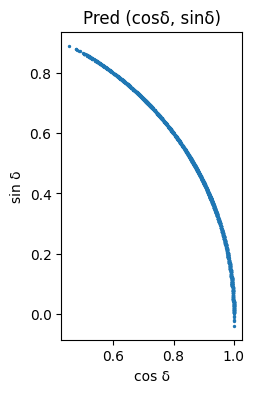

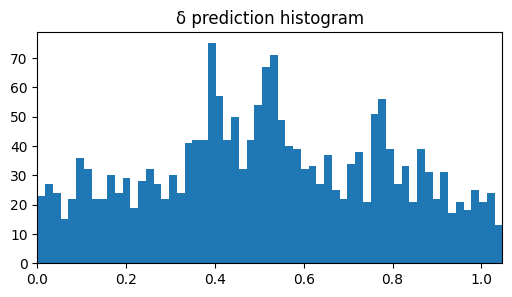

In [101]:
# ---------------- Quick diagnostics (scatter + hist) ----------------
def scatter_hist_on_loader(model, loader, title_prefix="Pred"):
    model.eval(); outs=[]
    with torch.no_grad():
        for x,c,_ in loader:
            o = model(x.to(device), c.to(device)).cpu().numpy()
            outs.append(o)
    outs = np.concatenate(outs,0)
    plt.figure(figsize=(4,4))
    plt.scatter(outs[:,0], outs[:,1], s=2)
    plt.gca().set_aspect('equal'); plt.title(f"{title_prefix} (cosŒ¥, sinŒ¥)")
    plt.xlabel("cos Œ¥"); plt.ylabel("sin Œ¥"); plt.show()

    delta = np.arctan2(outs[:,1], outs[:,0]) % (2*np.pi)
    plt.figure(figsize=(6,3)); plt.hist(delta, bins=60, range=(DELTA_MIN, DELTA_MAX))
    plt.xlim(DELTA_MIN, DELTA_MAX)
    plt.title("Œ¥ prediction histogram"); plt.show()

# ===== ÏÇ¨ÌõÑ Ï†êÍ≤Ä =====
model.load_state_dict(torch.load(ckpt_path, map_location=device))
scatter_hist_on_loader(model, val_loader, title_prefix="Pred")

ratio 3:4 | GT Œ¥=60.00¬∞ (1œÄ/3)
pred Œ¥=60.00¬∞ (1œÄ/3) | err=0.00¬∞


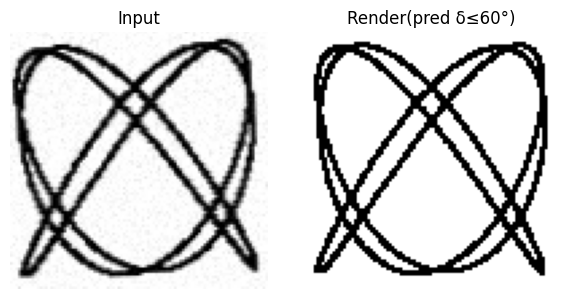

In [98]:
# ---------------- Tiny sanity inference ----------------
def canonical_delta_rad(delta_rad, a, b, clamp_pi_over_3=True):
    """Œ¥(rad)Î•º Î¶¨ÏÇ¨Ï£º Ï£ºÍ∏∞ Î∞è Ï¢åÏö∞Î∞òÏ†ÑÍπåÏßÄ Ï†ëÏñ¥ [0, œÄ¬∑a/b]Î°ú ÎßåÎì§Í≥†,
       ÌïÑÏöîÏãú [0, œÄ/3]Î°ú ÏµúÏ¢Ö Ï†úÌïú."""
    period = 2*math.pi * a / b          # 2œÄ¬∑a/b
    d = float(delta_rad % period)        # t-shift invariance
    d = min(d, period - d)               # mirror invariance
    if clamp_pi_over_3:
        d = min(d, math.pi/3)            # ÏµúÏ¢Ö [0, œÄ/3]
    return d

def predict_delta(model, pil_gray, a, b, side=SIDE):
    img = pil_gray.convert('L').resize((side, side), Image.BILINEAR)
    x = preprocess_to_tensor(img).unsqueeze(0).to(device)
    cond = torch.tensor([[a/6.0, b/6.0]], dtype=torch.float32, device=device)
    with torch.no_grad():
        vec = model(x, cond).cpu().numpy().reshape(2)
    delta = float(np.arctan2(vec[1], vec[0]) % (2*np.pi))
    return delta, img

# Ïòà: Ìï©ÏÑ± ÌïòÎÇòÎ•º ÎΩëÏïÑ ÌôïÏù∏ (GTÎèÑ canonical + ‚â§ œÄ/3Î°ú)
a, b = random.choice(RATIOS)
gt_delta_raw = random.uniform(0, 2*np.pi)
gt_delta = canonical_delta_rad(gt_delta_raw, a, b, clamp_pi_over_3=True)

img = draw_curve(SIDE, a, b, gt_delta, thickness=2)
img = apply_random_pose(img); img = overlay_grid(img); img = add_noise(img)

pred_raw, viz = predict_delta(model, img, a, b)
pred = canonical_delta_rad(pred_raw, a, b, clamp_pi_over_3=True)

def deg(x): return float(np.degrees(x))
def pi_frac(rad): return delta_to_pi_fraction(rad, max_den=180)

print(f"ratio {a}:{b} | GT Œ¥={deg(gt_delta):.2f}¬∞ ({pi_frac(gt_delta)})")
print(f"pred Œ¥={deg(pred):.2f}¬∞ ({pi_frac(pred)}) | err={abs(deg(pred)-deg(gt_delta)):.2f}¬∞")

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(viz, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(draw_curve(SIDE, a, b, pred, thickness=2), cmap='gray')
plt.title(f"Render(pred Œ¥‚â§60¬∞)"); plt.axis('off')
plt.tight_layout(); plt.show()

‚úÖ Loaded checkpoint: phase_cnn_best.pt


C:\Users\KOSJ\AppData\Local\Temp\ipykernel_20324\70703018.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device

‚Üí ratio = 3:4

===== Result =====
Image     : lsj 3 on 4.PNG
Œ¥_pred    : 52.79¬∞  (canonical, ‚â§60¬∞)
Œ¥_exp     : 0.00¬∞  (canonical, ‚â§60¬∞)
abs error : 52.79¬∞


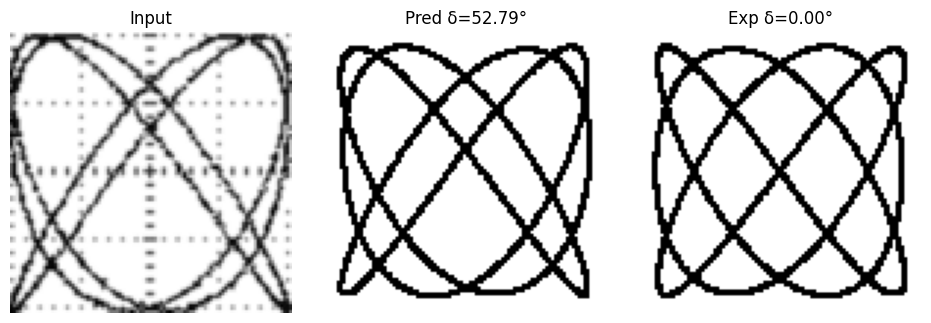

üìù Logged to: C:\Users\KOSJ\Downloads\inference_log.csv


In [99]:
import os, io, csv, math, json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw
from datetime import datetime

# ================= Inference on YOUR experiment image =================
if 'model' in globals() and 'device' in globals():
    if 'ckpt_path' in globals() and os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"‚úÖ Loaded checkpoint: {ckpt_path}")
    else:
        print("‚ÑπÔ∏è ckpt_pathÍ∞Ä ÏóÜÍ±∞ÎÇò ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. ÌòÑÏû¨ Î™®Îç∏ Í∞ÄÏ§ëÏπòÎ°ú ÏßÑÌñâÌï©ÎãàÎã§.")
else:
    raise RuntimeError("model/deviceÍ∞Ä Ï†ïÏùòÎêòÏñ¥ ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§. ÏúÑ ÌïôÏäµ ÏÖÄÎì§ÏùÑ Î®ºÏ†Ä Ïã§ÌñâÌïòÏÑ∏Ïöî.")

# ---- Lissajous Î≥¥Ï°∞ Ìï®ÏàòÎì§ ----
def canonical_delta_rad(delta_rad, a, b, clamp_pi_over_3=True):
    """Œ¥(rad)Î•º Î¶¨ÏÇ¨Ï£º Ï£ºÍ∏∞(2œÄ¬∑a/b) Î∞è Ï¢åÏö∞Î∞òÏ†ÑÍπåÏßÄ Ï†ëÏñ¥ [0, œÄ¬∑a/b]Î°ú ÎßåÎì§Í≥†,
       ÌïÑÏöîÏãú ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú [0, œÄ/3]Î°ú Ï†úÌïú."""
    period = 2*math.pi * a / b
    d = float(delta_rad % period)
    d = min(d, period - d)
    if clamp_pi_over_3:
        d = min(d, math.pi/3)
    return d

def delta_to_deg(rad): return float(np.degrees(rad))
def deg_to_rad(deg):  return float(np.radians(deg))

def draw_curve_quick(size, a, b, delta, thickness=2, margin=0.06):
    t = np.linspace(0, 2*np.pi, 1500)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    x = x/(np.max(np.abs(x))+1e-9); y = y/(np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    img = Image.new('L', (size, size), 255)
    ImageDraw.Draw(img).line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

def predict_delta(model, pil_gray, a, b, side=SIDE):
    """ÌòÑÏû¨ Î™®Îç∏Î°ú Œ¥(rad) ÏòàÏ∏° + Ï†ÑÏ≤òÎ¶¨Îêú ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ Î∞òÌôò"""
    img = pil_gray.convert('L').resize((side, side), Image.BILINEAR)
    x = preprocess_to_tensor(img).unsqueeze(0).to(device)
    cond = torch.tensor([[a/6.0, b/6.0]], dtype=torch.float32, device=device)
    with torch.no_grad():
        vec = model(x, cond).cpu().numpy().reshape(2)
    delta = float(np.arctan2(vec[1], vec[0]) % (2*np.pi))
    return delta, img

# ---- VSCode/ÎÖ∏Ìä∏Î∂ÅÏóêÏÑú Ïù¥ÎØ∏ÏßÄ ÏÑ†ÌÉù(ÏúÑÏ†Ø ÏûàÏúºÎ©¥ ÏóÖÎ°úÎìú, ÏóÜÏúºÎ©¥ Í≤ΩÎ°ú/ÏûêÎèôÌÉêÏÉâ) ----
def pick_image_vscode():
    # 1) ipywidgets ÏóÖÎ°úÎìú ÏãúÎèÑ
    try:
        import ipywidgets as widgets
        from IPython.display import display, clear_output

        uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg,.bmp', multiple=False)
        btn_done = widgets.Button(description='Use this file', button_style='success')
        out = widgets.Output()

        selected = {'pil': None, 'name': None}

        def on_upload_change(change):
            for _, f in uploader.value.items():
                selected['name'] = f['metadata'].get('name', 'uploaded.png')
                selected['pil']  = Image.open(io.BytesIO(f['content']))
                with out:
                    clear_output(wait=True)
                    print(f"‚úÖ Uploaded: {selected['name']}")
                    display(selected['pil'])

        def on_done_clicked(b):
            if selected['pil'] is None:
                with out:
                    print("‚ö†Ô∏è Î®ºÏ†Ä Ïù¥ÎØ∏ÏßÄÎ•º ÏóÖÎ°úÎìúÌïòÏÑ∏Ïöî.")
            else:
                with out:
                    print("‚úÖ Using uploaded image.")

        uploader.observe(on_upload_change, names='value')
        btn_done.on_click(on_done_clicked)

        display(widgets.VBox([widgets.HTML("<b>Ïù¥ÎØ∏ÏßÄ ÏóÖÎ°úÎìú</b>"), uploader, btn_done, out]))

        # ÎåÄÌôîÌòï ÎåÄÍ∏∞ ÏóÜÏù¥ÎèÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÍ≤å, ÏóÖÎ°úÎìúÍ∞Ä ÏóÜÏúºÎ©¥ ÏïÑÎûò fallbackÏúºÎ°ú ÏßÑÌñâ
        print("‚ÑπÔ∏è ÏúÑÏ†ØÏù¥ Î≥¥Ïù¥ÏßÄ ÏïäÍ±∞ÎÇò ÏóÖÎ°úÎìúÌïòÏßÄ ÏïäÏúºÎ©¥ Í≤ΩÎ°ú ÏûÖÎ†•/ÏûêÎèôÌÉêÏÉâÏúºÎ°ú ÎÑòÏñ¥Í∞ëÎãàÎã§.")
    except Exception:
        pass

    # 2) Í≤ΩÎ°ú ÏßÅÏ†ë ÏûÖÎ†•
    try:
        path_in = input("Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÎ•º ÏûÖÎ†•(ÏóîÌÑ∞=ÏûêÎèôÌÉêÏÉâ): ").strip()
    except Exception:
        path_in = ""

    if path_in:
        p = Path(path_in).expanduser()
        if not p.exists():
            raise FileNotFoundError(f"Not found: {p}")
        return Image.open(p), p.name

    # 3) ÌòÑÏû¨ Ìè¥Îçî ÏûêÎèô ÌÉêÏÉâ
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    cwd = Path(".").resolve()
    cands = []
    for e in exts:
        cands += list(cwd.glob(e))
    if not cands:
        raise FileNotFoundError(f"ÌòÑÏû¨ Ìè¥Îçî({cwd})Ïóê Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§. Í≤ΩÎ°úÎ•º ÏßÅÏ†ë ÏûÖÎ†•ÌïòÏÑ∏Ïöî.")
    # Ï≤´ Î≤àÏß∏ ÏûêÎèô ÏÑ†ÌÉù (Î™©Î°ù Î≥¥Ïó¨Ï£ºÍ∏∞)
    print("üîé Found images:")
    for i, p in enumerate(cands, 1):
        print(f"  [{i}] {p.name}")
    print(f"‚û°Ô∏è ÏûêÎèô ÏÑ†ÌÉù: {cands[0].name}")
    return Image.open(cands[0]), cands[0].name

# ---- Ïã§Ìñâ: ratio/Ïù¥ÎØ∏ÏßÄ/Ïã§ÌóòÍ∞í ÏûÖÎ†• ‚Üí ÏòàÏ∏°/ÎπÑÍµê/ÏãúÍ∞ÅÌôî/Î°úÍπÖ ----
def parse_ratio(s):
    s = s.strip()
    if ":" in s: a,b = s.split(":")
    else:        a,b = s.split()
    return int(a), int(b)

ratio_str = input("Í∞ÅÏßÑÎèôÏàò ÎπÑÎ•º ÏûÖÎ†•ÌïòÏÑ∏Ïöî (Ïòà: 1:3) : ").strip() or "1:3"
a, b = parse_ratio(ratio_str)
print(f"‚Üí ratio = {a}:{b}")

pil_in, img_name = pick_image_vscode()

# ÏòàÏ∏°
pred_raw, viz = predict_delta(model, pil_in, a, b)
pred_canon = canonical_delta_rad(pred_raw, a, b, clamp_pi_over_3=True)
pred_deg   = delta_to_deg(pred_canon)

# Ïã§ÌóòÍ∞í(ÏòµÏÖò)
gt_str = input("Ïã§Ìóò Œ¥(ÎèÑ, ÎπÑÏö∞Î©¥ Ïä§ÌÇµ): ").strip()
gt_deg = float(gt_str) if gt_str else np.nan
gt_canon = canonical_delta_rad(deg_to_rad(gt_deg), a, b, clamp_pi_over_3=True) if gt_str else np.nan
gt_canon_deg = delta_to_deg(gt_canon) if gt_str else np.nan

# ÏóêÎü¨
err_deg = abs(pred_deg - gt_canon_deg) if gt_str else np.nan

# Ï∂úÎ†•
print("\n===== Result =====")
print(f"Image     : {img_name}")
print(f"Œ¥_pred    : {pred_deg:.2f}¬∞  (canonical, ‚â§60¬∞)")
if gt_str:
    print(f"Œ¥_exp     : {gt_canon_deg:.2f}¬∞  (canonical, ‚â§60¬∞)")
    print(f"abs error : {err_deg:.2f}¬∞")

# ÏãúÍ∞ÅÌôî (Input / Pred / Exp(optional))
ncols = 3 if gt_str else 2
plt.figure(figsize=(3.2*ncols, 3.2))
plt.subplot(1,ncols,1); plt.imshow(viz, cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,ncols,2); plt.imshow(draw_curve_quick(SIDE, a, b, deg_to_rad(pred_deg), thickness=2), cmap='gray')
plt.title(f"Pred Œ¥={pred_deg:.2f}¬∞"); plt.axis('off')
if gt_str:
    plt.subplot(1,ncols,3); plt.imshow(draw_curve_quick(SIDE, a, b, deg_to_rad(gt_canon_deg), thickness=2), cmap='gray')
    plt.title(f"Exp Œ¥={gt_canon_deg:.2f}¬∞"); plt.axis('off')
plt.tight_layout(); plt.show()

# CSV Î°úÍπÖ (inference_log.csv)
log_row = {
    "timestamp": datetime.now().isoformat(timespec='seconds'),
    "image": img_name,
    "ratio": f"{a}:{b}",
    "pred_deg_canon_le60": round(pred_deg, 6),
    "exp_deg_canon_le60": round(gt_canon_deg, 6) if gt_str else "",
    "abs_error_deg": round(err_deg, 6) if gt_str else "",
}
csv_path = Path("inference_log.csv")
write_header = not csv_path.exists()
with csv_path.open("a", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(log_row.keys()))
    if write_header: w.writeheader()
    w.writerow(log_row)
print(f"üìù Logged to: {csv_path.resolve()}")

In [76]:

# ===== RUN TRAIN =====
print("Starting training with anti-collapse settings‚Ä¶")
# assumes model/train_loader/val_loader defined above
# You can adjust EPOCHS/LR earlier cells; we reuse as-is


Starting training with anti-collapse settings‚Ä¶
